In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict

import celldetection as cd
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.legend_handler import HandlerLine2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import regionprops
from torchvision import transforms

In [3]:
from quantitative_cells import read_label_h5, analyse_cell_counts
from zse.utils.data_utils import read_h5

In [4]:
def labels2contours(labels, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE) -> dict:
    """

    Args:
        labels:
        mode:
        method: Contour method. CHAIN_APPROX_NONE must be used if contours are used for CPN.

    Returns:

    """
    crops = []
    contours = OrderedDict({})
    for channel in np.split(labels, labels.shape[2], 2):
        crops += [(p.label, p.image) + p.bbox[:2] for p in regionprops(channel)]
    for label, crop, oy, ox in crops:
        crop.dtype = np.uint8
        r = cv2.findContours(crop, mode=mode, method=method, offset=(ox, oy))
        if len(r) == 3:  # be compatible with both existing versions of findContours
            _, c, _ = r
        elif len(r) == 2:
            c, _ = r
        else:
            raise NotImplementedError('try different cv2 version')
        c, = c
        if len(c) == 1:
            c = np.concatenate((c, c), axis=0)  # min len for other functions to work properly
        contours[label] = c
    return contours

In [5]:
def labels2contour_list(labels) -> list:
    if labels.ndim == 2:
        labels = labels[..., None]
    d = labels2contours(labels)
    return [np.squeeze(v, 1) for k,v in sorted(d.items(), key=lambda x: x[0])]

In [6]:
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(2)

In [7]:
def plot_cross_section(z_stack, idx, z_depth, contours_t=None, contours_fp=None, contours_fn=None, fname=None):
    z_stack = z_stack.detach().clone().cpu().squeeze(1)
    z, y, x = idx
    # yx
    a = z_stack[z, :, :]
    # zx = top
    b = z_stack[:, y, :]
    # yz = right
    c = z_stack[:, :, x].transpose(0, 1)

    fig, main_ax = plt.subplots(figsize=(10, 10))
    divider = make_axes_locatable(main_ax)
    pad = 0.01
    # if z_depth > 20:
    #     pad *= 10
    top_ax = divider.append_axes("top", 1, pad=pad, sharex=main_ax)
    right_ax = divider.append_axes("right", 1, pad=pad, sharey=main_ax)

    main_ax.tick_params(colors='black', which='both')
    top_ax.tick_params(colors='black', which='both')
    right_ax.tick_params(colors='black', which='both')

    ticks = [i*10 for i in range(round(z_depth/10))] + [z_depth-1]
    top_ax.set_yticks(ticks)
    right_ax.set_xticks(ticks)

    main_ax.xaxis.set_tick_params(color='black')
    top_ax.xaxis.set_tick_params(labelbottom=False, color='black')
    right_ax.yaxis.set_tick_params(labelleft=False, color='black')

    main_ax.set_xlabel('X', color='black')
    main_ax.set_ylabel('Y', color='black')
    top_ax.set_ylabel('Z', color='black')
    right_ax.set_xlabel('Z', color='black')

    main_ax.imshow(a, cmap='gray', vmin=0, vmax=1, origin='lower')
    top_ax.imshow(b, cmap='gray', vmin=0, vmax=1)
    right_ax.imshow(c, cmap='gray', vmin=0, vmax=1)

    if contours_t is not None:
        label = "TP segmented cells" if contours_fn is not None or contours_fp is not None else "Segmented cells"
        color = "lime" if "TP" in label else "lightblue"
        for c_ in contours_t:
            c_ = np.concatenate((c_, c_[:1]), 0)  # close contour
            c_ = np.clip(c_, 0, 255)
            main_ax.plot(c_[:, 0], c_[:, 1], linestyle='-', linewidth=1, color=color, label=label)
            label = None
    if contours_fp is not None:
        label = "FP segmented cells in generated z-stack"
        for c_ in contours_fp:
            c_ = np.concatenate((c_, c_[:1]), 0)  # close contour
            c_ = np.clip(c_, 0, 255)
            main_ax.plot(c_[:, 0], c_[:, 1], linestyle='-', linewidth=1, color="red", label=label)
            label = None
    if contours_fn is not None:
        label = "FN segmented cells in original z-stack"
        for c_ in contours_fn:
            c_ = np.concatenate((c_, c_[:1]), 0)  # close contour
            c_ = np.clip(c_, 0, 255)
            main_ax.plot(c_[:, 0], c_[:, 1], linestyle='-', linewidth=1, color="yellow", label=label)
            label = None

    main_ax.axhline(y, color='b')
    main_ax.axvline(x, color='b')
    top_ax.axhline(z, color='b')
    top_ax.axvline(x, color='b')
    right_ax.axhline(y, color='b')
    right_ax.axvline(z, color='b')
    main_ax.autoscale(enable=False)
    right_ax.autoscale(enable=False)
    top_ax.autoscale(enable=False)
    right_ax.set_xlim(right=z_depth-0.5)
    top_ax.set_ylim(bottom=z_depth-0.5)

    main_ax.invert_yaxis()
    top_ax.invert_yaxis()

    # main_ax.legend(bbox_to_anchor=(0, -0.21, 1, 0.1), loc='upper center', mode="expand", borderaxespad=0., handler_map={plt.Line2D : HandlerLine2D(update_func=update)})

    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.1)

    plt.show()

In [29]:
def plot(img, contours_t=None, contours_fp=None, contours_fn=None, fname=None):
    img = img.min(0)[0]
    img = img.squeeze().detach().cpu().numpy()

    plt.figure(dpi=100)

    if contours_t is not None:
        label = "TP segmented cells" if contours_fn is not None or contours_fp is not None else "Segmented cells"
        color = "lime" if "TP" in label else "lightblue"
        for c_ in contours_t:
            c_ = np.concatenate((c_, c_[:1]), 0)  # close contour
            c_ = np.clip(c_, 0, 255)
            plt.plot(c_[:, 0], c_[:, 1], linestyle='-', linewidth=1, color=color, label=label)
            label = None
    if contours_fp is not None:
        label = "FP segmented cells in generated z-stack"
        for c_ in contours_fp:
            c_ = np.concatenate((c_, c_[:1]), 0)  # close contour
            c_ = np.clip(c_, 0, 255)
            plt.plot(c_[:, 0], c_[:, 1], linestyle='-', linewidth=1, color="red", label=label)
            label = None
    if contours_fn is not None:
        label = "FN segmented cells in original z-stack"
        for c_ in contours_fn:
            c_ = np.concatenate((c_, c_[:1]), 0)  # close contour
            c_ = np.clip(c_, 0, 255)
            plt.plot(c_[:, 0], c_[:, 1], linestyle='-', linewidth=1, color="yellow", label=label)
            label = None

    plt.imshow(img, cmap="gray", origin="lower")
    plt.axis("off")
    # plt.legend(bbox_to_anchor=(0., -0.24, 1., .102), loc='lower center', mode="expand", borderaxespad=0., handler_map={plt.Line2D : HandlerLine2D(update_func=update)})

    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0)
    plt.show()

In [8]:
data_source = f"/p/fastdata/bigbrains/personal/crijnen1/data/bigbrain_1micron/20/test"
labels_source = f"/p/fastdata/bigbrains/personal/crijnen1/data/CPN"
dest_qual = f"../../reports/results/brain/qualitative_cells"
dest_quant = f"../../reports/results/brain/quantitative"

In [9]:
z_depth = 20
models = ["blurry", "adain_unet_2d", "adain_unet_3d", "adain_unet_3ds", "unet_3ds"]
to_tensor = transforms.ToTensor()

# Qualitative

In [40]:
# fname = "B21_0371_y39740_x18220.hdf5"
# offset = xs, ys = (0, 256)
# fname = "B21_1961_y86767_x27492.hdf5"
# offset = xs, ys = (0, 0)
fname = "B21_4780_y55105_x50026.hdf5"
offset = xs, ys = (256, 0)

size = 256

In [41]:
z_stacks = {model: to_tensor(read_h5(f"{data_source}/{model}/{fname}"))[:, ys:ys+size, xs:xs+size] for model in models}
labels = {model: read_label_h5(f"{labels_source}/{model}/{fname}") for model in models}

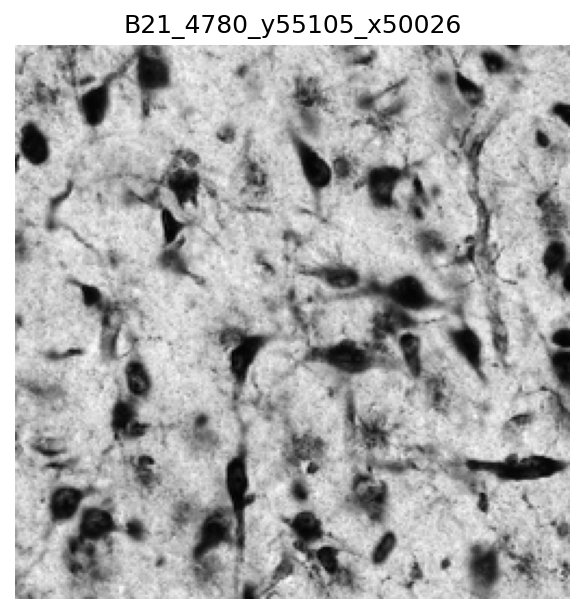

In [42]:
plt.figure(dpi=150)
plt.title(fname[:-5])
plt.imshow(z_stacks["blurry"][9], cmap="gray", origin="lower")
plt.axis("off")
plt.show()

In [43]:
results = {}
contours = {}
for k, labels_ in labels.items():
    contours[k] = []

    if k == "blurry":
        results[k] = []
    else:
        results[k] = cd.data.LabelMatcherList()

    for i in range(labels_.shape[0]):
        contours[k].append(labels2contour_list(labels_[i]))

        if k == "blurry":
            labels_tar = np.unique(labels_[i, ys:ys+size, xs:xs+size])
            results[k].append(labels_tar[labels_tar > 0] - 1)
        else:
            res = cd.data.LabelMatcher(labels_[i, ys:ys+size, xs:xs+size], labels["blurry"][i, ys:ys+size, xs:xs+size])
            results[k].append(res)

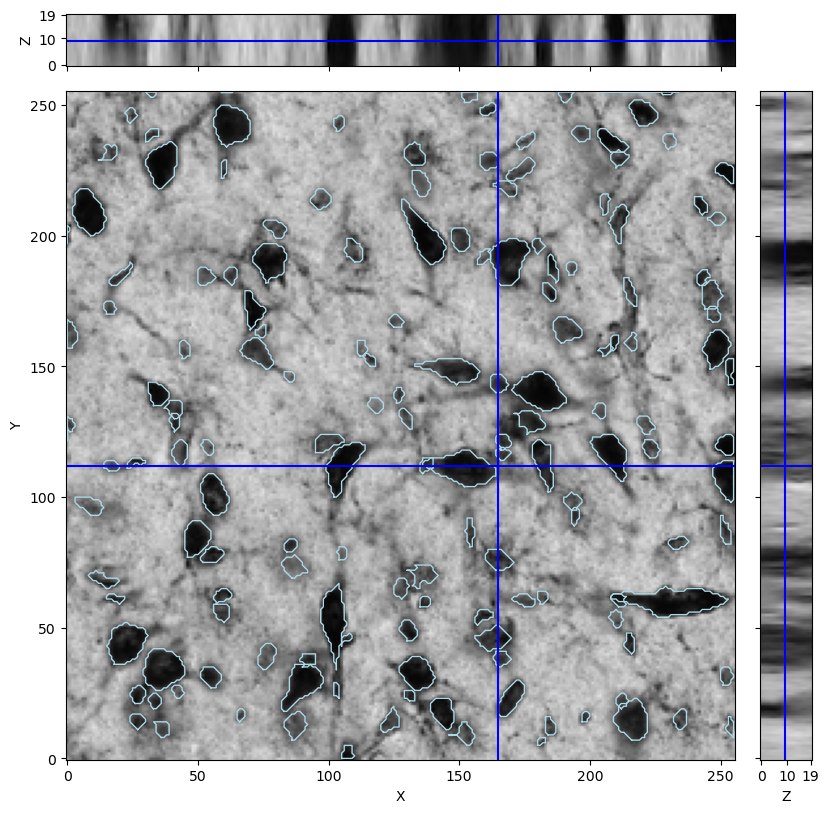

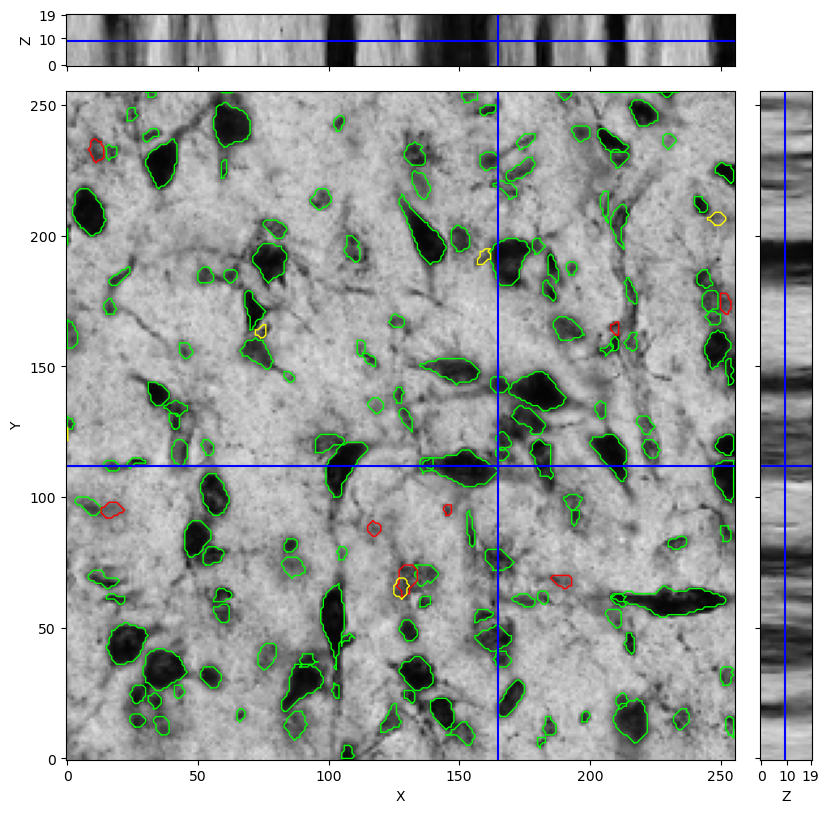

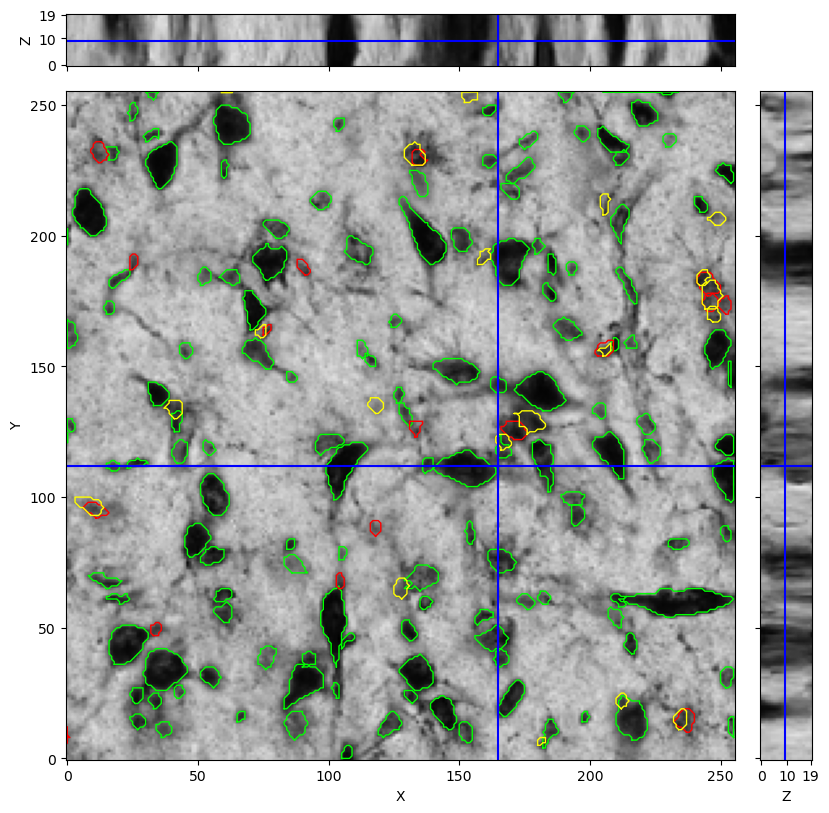

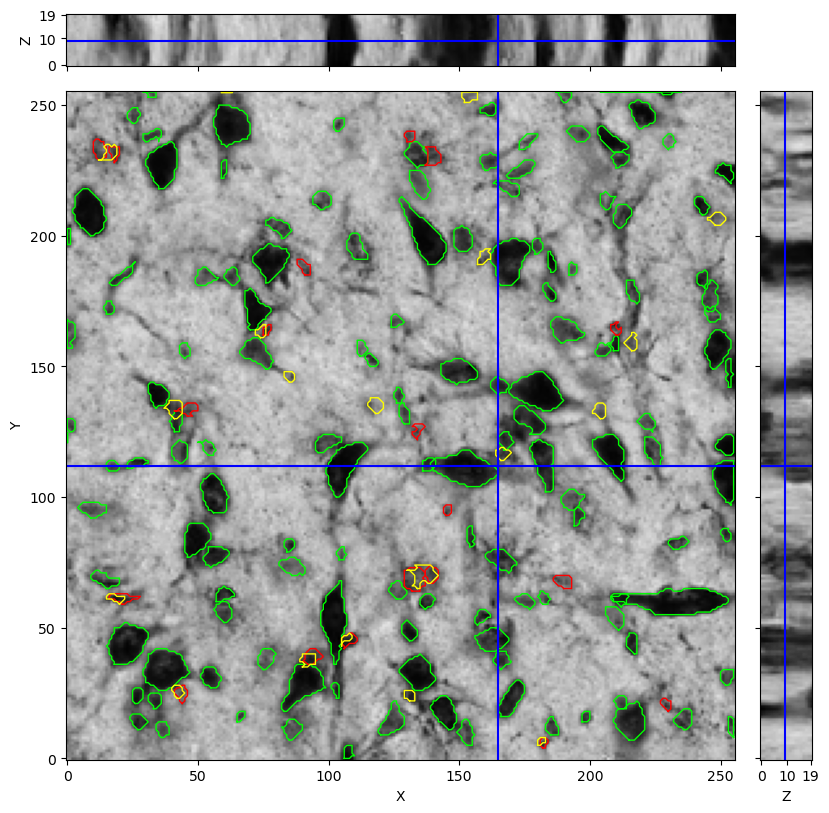

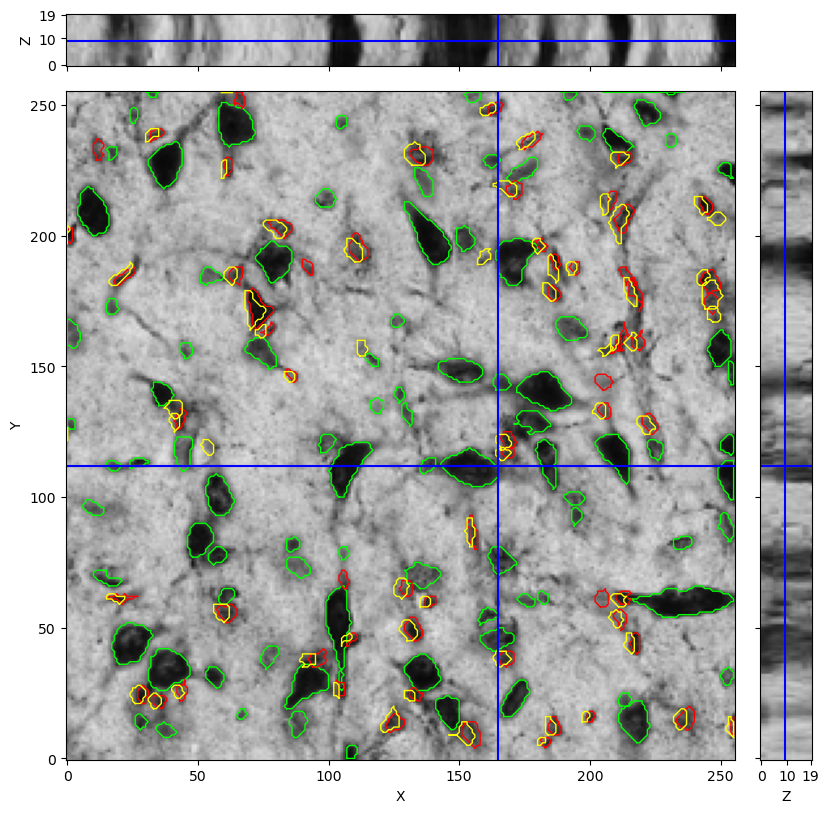

In [26]:
z = 9
# idx = (z, 155, 142)
# idx = (z, 190, 112)
idx = (z, 112, 165)

for k, c in contours.items():
    path = f"{dest_qual}/{fname[:-5]}_z{z:02}_{k}"
    # path = None
    res = results[k][z]
    if k == "blurry":
        cont = [c[z][i] - offset for i in res]
        plot_cross_section(z_stacks[k], idx, 20, cont, fname=path)
    else:
        t = contours["blurry"]
        res.iou_thresh = 0.5

        idx_tp = np.array(list(res.true_positive_labels)) - 1
        idx_fp = np.array(list(res.false_positive_labels)) - 1
        idx_fn = np.array(list(res.false_negative_labels)) - 1

        cont_tp = [c[z][i] - offset for i in idx_tp]
        cont_fp = [c[z][i] - offset for i in idx_fp]
        cont_fn = [t[z][i] - offset for i in idx_fn]
        plot_cross_section(z_stacks[k], idx, 20, cont_tp, cont_fp, cont_fn, fname=path)

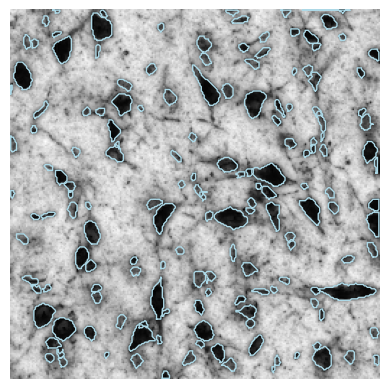

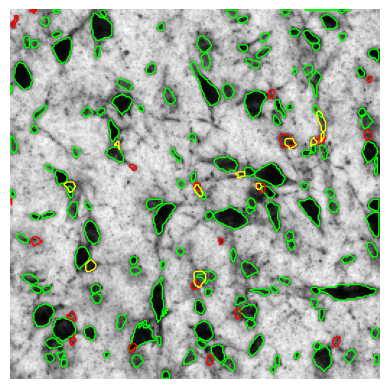

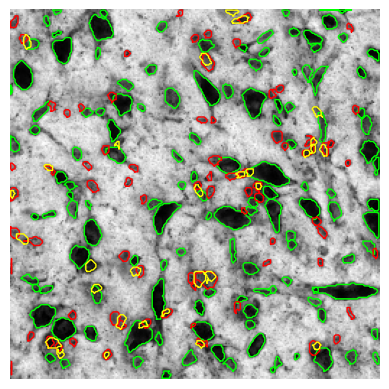

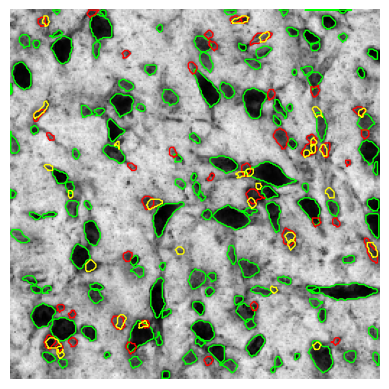

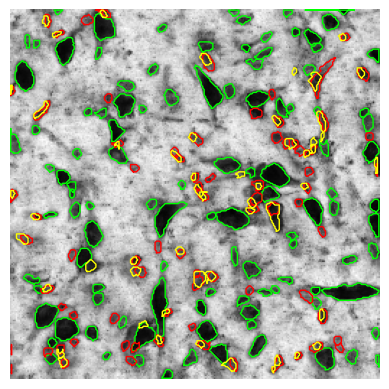

In [44]:
z = 20

for k, c in contours.items():
    path = f"{dest_qual}/{fname[:-5]}_min_{k}"
    # path = None
    res = results[k][z]
    if k == "blurry":
        cont = [c[z][i] - offset for i in res]
        plot(z_stacks[k], cont, fname=path)
    else:
        t = contours["blurry"]
        res.iou_thresh = 0.5

        idx_tp = np.array(list(res.true_positive_labels)) - 1
        idx_fp = np.array(list(res.false_positive_labels)) - 1
        idx_fn = np.array(list(res.false_negative_labels)) - 1

        cont_tp = [c[z][i] - offset for i in idx_tp]
        cont_fp = [c[z][i] - offset for i in idx_fp]
        cont_fn = [t[z][i] - offset for i in idx_fn]
        plot(z_stacks[k], cont_tp, cont_fp, cont_fn, fname=path)

# Quantitative

In [ ]:
df_adain_unet_3d_small = analyse_cell_counts("adain_unet_3ds", labels_source, z_depth, dest_quant)

In [ ]:
df_adain_unet_3d = analyse_cell_counts("adain_unet_3d", labels_source, z_depth, dest_quant)

In [ ]:
df_adain_unet_2d = analyse_cell_counts("adain_unet_2d", labels_source, z_depth, dest_quant)

In [ ]:
df_unet_3d_small = analyse_cell_counts("unet_3ds", labels_source, z_depth, dest_quant)